In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from conditional_inference.bayes.classic import LinearClassicBayes
from conditional_inference.bayes.empirical import LinearEmpiricalBayes
from conditional_inference.utils import holm_bonferroni_correction
from conditional_inference.rqu import RQU
from linearmodels.panel.model import PanelOLS
from scipy.stats import multivariate_normal

sns.set()

In [26]:
df = pd.read_csv("../data/raw/effort_experiment.csv")
df = df.dropna(subset=["treatment_index", "target"])
df = df[df.target < 4000]
df["arm"] = df.treatment_index.map({i: f"haystack_{str(i).zfill(2)}" if i > 0 else "needle" for i in np.arange(20)})
df.head()

id  completed  failed  errored  in_progress                  start_time  \
0    7       True   False    False        False  2022-01-13 14:31:20.964841   
1   54       True   False    False        False  2022-01-13 15:03:22.445610   
2    2       True   False    False        False  2022-01-13 14:08:01.497511   
3  101       True   False    False        False  2022-01-13 15:35:41.471879   
4    1       True   False    False        False  2022-01-13 13:48:55.885786   

                     end_time  total_seconds                           hitId  \
0  2022-01-13 14:32:22.657944      61.693103  3O4VWC1GEW6TV568NCVWG4IWSQDJ3Y   
1  2022-01-13 16:52:02.866192    6520.420582                             NaN   
2  2022-01-13 14:09:27.441430      85.943919                             NaN   
3  2022-01-13 15:37:58.483796     137.011917  3D06DR5225JJGYBEZONYJ4OJ2U0AMP   
4  2022-01-13 13:49:46.979034      51.093248                             NaN   

         workerId  ... treatment_index        mturk_id   age  gender  \
0   AM65LGXJBTJ0I  ...            18.0   AM65LGXJBTJ0I  32.0    Male   
1             NaN  ...             0.0   AMI0SOF51O3FW  37.0    Male   
2             NaN  ...            12.0            Test  33.0  Female   
3  A3C5G8LGIAW0XL  ...            15.0  A3C5G8LGIAW0XL  37.0  Female   
4             NaN  ...            17.0            test  29.0    Male   

  practice_time   task_time  target payment next          arm  
0      6.623586   15.009418    52.0     0.0  NaN  haystack_18  
1     30.600329  600.635193  3056.0    30.0  NaN       needle  
2     11.186486   25.465193    91.0     0.0  NaN  haystack_12  
3     31.838572   41.437008    52.0     0.0  NaN  haystack_15  
4     29.519005    3.295573     0.0     0.0  NaN  haystack_17  

[5 rows x 29 columns]

In [29]:
needle_mask = df.treatment_index == 0
hay_df = df[~needle_mask]
hay_df.shape

(360, 29)

In [31]:
n_arms = 20
n_obs = 1000
n_obs_per_arm = int(n_obs / n_arms)

def sample_hay_df(i):
    df = hay_df.sample(n_obs_per_arm, replace=True)
    df["treatment_index"] = 1
    return df

In [56]:
simulated_df = pd.concat([df[needle_mask].sample(n_obs_per_arm, replace=True)] + [sample_hay_df(i) for i in range(n_arms - 1)])
simulated_df.shape

(1000, 29)

In [57]:
ols_results = sm.OLS(simulated_df.target, pd.get_dummies(simulated_df.arm)).fit().get_robustcov_results()
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                nan
Time:                        13:01:19   Log-Likelihood:                -8132.8
No. Observations:                1000   AIC:                         1.631e+04
Df Residuals:                     980   BIC:                         1.640e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
haystack_01   761.3182    180.999      4.206      0.000     406.127    1116.509
haystack_02   304.1500     81.245      3.744      0.000     144.715     463.585
haystack_03   206.7778     90.398      2.287      0.022      29.381     384.175
haystack_04   496.4082     95.226      5.213      0.000     309.539     683.278
haystack_05   772.8205    146.748      5.266      0.000     484.844    1060.797
haystack_06   860.0833     83.629     10.285      0.000     695.971    1024.195
haystack_07    36.5000     28.843      1.265      0.206     -20.101      93.101
haystack_08   569.6552    123.769      4.603      0.000     326.772     812.538
haystack_09   943.5892     72.979     12.930      0.000     800.376    1086.802
haystack_10   744.2667    114.085      6.524      0.000     520.387     968.146
haystack_11   422.9091    151.107      2.799      0.005     126.379     719.439
haystack_12    48.1111      9.527      5.050      0.000      29.415      66.807
haystack_13   469.0833    133.054      3.526      0.000     207.980     730.187
haystack_14   102.2000     27.525      3.713      0.000      48.185     156.215
haystack_15   234.7895    122.202      1.921      0.055      -5.019     474.598
haystack_16   260.4286     70.287      3.705      0.000     122.499     398.358
haystack_17   972.1789     51.917     18.726      0.000     870.298    1074.060
haystack_18   237.7368     52.706      4.511      0.000     134.308     341.166
haystack_19   194.2500     46.767      4.154      0.000     102.475     286.025
needle        870.3000    124.565      6.987      0.000     625.856    1114.744
==============================================================================
Omnibus:                      117.154   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.866
Skew:                           0.680   Prob(JB):                     5.61e-22
Kurtosis:                       2.294   Cond. No.                         6.69
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [20]:
recommended_arm = ols_results.model.exog_names[ols_results.params.argmax()]
recommended_arm

'needle'

In [21]:
projection_results = RQU.from_results(ols_results).fit(cols=[recommended_arm], projection=True)
projection_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Projection estimates                    
=============================================================
       coef (conventional) pvalue 0.95 CI lower 0.95 CI upper
-------------------------------------------------------------
needle            1212.014  0.000       945.774      1478.254
====================
Dep. Variable target
--------------------
"""

In [64]:
ax_len_ci = np.diff(projection_results.conf_int())[0][0]
ax_len_ci

532.4793448874293

In [67]:
df = pd.read_csv("../simulations/experiment/data/data.csv")
df.head()

n_obs  n_arms  recommended_needle       len_ci  sim_no
0   1000      20                True   984.611375      23
1   1000      30                True  1178.828450      23
2   1000      40               False  1311.980421      23
3   1000      50                True  1443.594183      23
4   1000      60               False  1771.051426      23

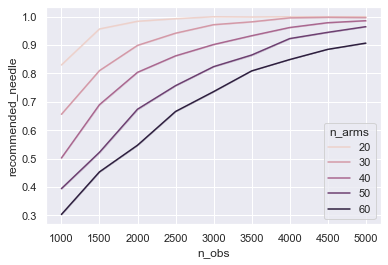

In [68]:
sns.lineplot(data=df, x="n_obs", y="recommended_needle", hue="n_arms", ci=False)
plt.show()

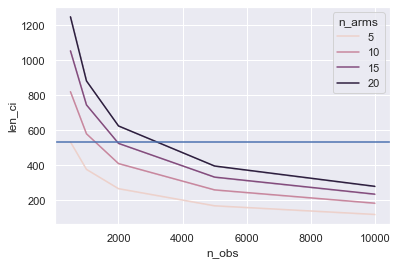

In [66]:
ax = sns.lineplot(data=df, x="n_obs", y="len_ci", hue="n_arms", ci=False)
ax.axhline(ax_len_ci)